In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

In [2]:
train_dir = '../input/fitzpatrick-classification-by-ethnicity/fairface/fairface/train'
test_dir = '../input/fitzpatrick-classification-by-ethnicity/fairface/fairface/val'

In [3]:
trainfinal=pd.read_csv('../input/fitzpatrick-classification-by-ethnicity/fitz_undersampled_train_final.csv')
trainfinal

,file,age,gender,race,phototype
0,1.jpg,50-59,Male,East Asian,III
1,10.jpg,30-39,Male,Middle Eastern,V
2,100.jpg,20-29,Female,East Asian,III
3,1000.jpg,30-39,Male,White,I & II
4,10004.jpg,40-49,Male,Indian,V
...,...,...,...,...,...
35425,9659.jpg,30-39,Female,Black,VI
35426,967.jpg,40-49,Female,Black,VI
35427,9676.jpg,30-39,Female,Black,VI
35428,9703.jpg,20-29,Female,Black,VI


In [4]:
testfinal=pd.read_csv('../input/fitzpatrick-classification-by-ethnicity/fitz_undersampled_test_final.csv')
testfinal

,file,age,gender,race,phototype
0,100.jpg,20-29,Female,East Asian,III
1,1000.jpg,20-29,Male,Latino_Hispanic,IV
2,10000.jpg,20-29,Female,East Asian,III
3,10001.jpg,20-29,Female,Southeast Asian,V
4,10004.jpg,20-29,Male,Southeast Asian,V
...,...,...,...,...,...
4510,9476.jpg,30-39,Female,Black,VI
4511,9501.jpg,40-49,Female,Black,VI
4512,9560.jpg,30-39,Female,Black,VI
4513,9561.jpg,20-29,Female,Black,VI


In [5]:
Name = trainfinal['phototype'].unique().tolist()
print(Name)
print(len(Name))

['III', 'V', 'I & II', 'IV', 'VI']
5


In [6]:
Class_count_1, Class_count_2, Class_count_3, Class_count_4,Class_count_5= trainfinal['phototype'].value_counts()
# Separate class
Class_count_1 = trainfinal[trainfinal['phototype'] == "I & II"]
Class_count_2 = trainfinal[trainfinal['phototype'] == "III"]
Class_count_3 = trainfinal[trainfinal['phototype'] == "IV"]
Class_count_4 = trainfinal[trainfinal['phototype'] == "V"]
Class_count_5 = trainfinal[trainfinal['phototype'] == "VI"]# print the shape of the class
print('class 1:', Class_count_1.shape)
print('class 2:', Class_count_2.shape)
print('class 3:', Class_count_3.shape)
print('class 4:', Class_count_4.shape)
print('class 5:', Class_count_5.shape)

class 1: (7086, 5)
class 2: (7086, 5)
class 3: (7086, 5)
class 4: (7086, 5)
class 5: (7086, 5)


In [7]:
N=list(range(len(Name)))
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

In [8]:
trainfinal['phototype2']=trainfinal['phototype'].map(normal_mapping)
testfinal['phototype2']=testfinal['phototype'].map(normal_mapping)

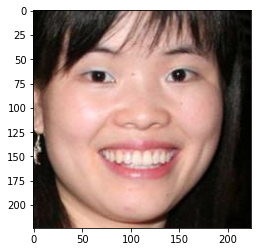

image size: (224, 224, 3)


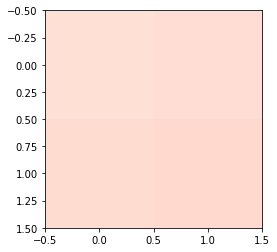

image size: (2, 2, 3)


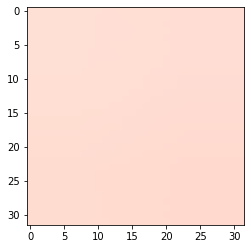

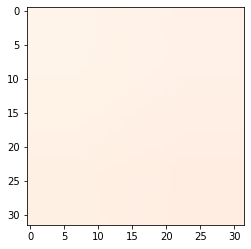

In [9]:
path0='../input/fitzpatrick-classification-by-ethnicity/fairface/fairface/train/100.jpg'
image=cv2.imread(path0)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()
sp=image.shape
print('image size:', sp)
#sp[0]=height, sp[1]=width


image2=image[110:112, 110:112,:]
plt.imshow(cv2.cvtColor(image2,cv2.COLOR_BGR2RGB))
plt.show()
print('image size:', image2.shape)
image3=cv2.resize(image2,(32,32)) 
#image3=cv2.resize(image2,dsize=(32,32),interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(image3,cv2.COLOR_BGR2RGB))
plt.show()

M = np.ones(image3.shape, dtype='uint8') * 20
img_bright = cv2.add(image3, M)
plt.imshow(cv2.cvtColor(img_bright,cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
!pip install skin-tone-classifier

     |████████████████████████████████| 61.8 MB 230 kB/s  eta 0:00:01
     |████████████████████████████████| 15.7 MB 34.3 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 5.4 MB/s  eta 0:00:01
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39408 sha256=0a883e845f1f39116ba5c2d9cce4cf2acf0c32c385311306a8cb7ffe3d3af1bd
  Stored in directory: /root/.cache/pip/wheels/1a/d7/a7/458a4632ccc8bfe436f5e9db9fef1aa84e5d243a1b4b4c7b59
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=347d1e23b531652423e2e98fc2c63e6ea27b00a0c99a1663a9fe2771720349ab
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built colormath imutils
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.1
    Unin

In [11]:
trainX=[]
trainY0=[]
for im in tqdm(os.listdir(train_dir)):
    image=cv2.imread(os.path.join(train_dir,im))
    if im[-4:]=='.jpg':
        lists=trainfinal[trainfinal['file']==im]['phototype2'].tolist()
        if len(lists)==1:
            count=lists[0]
            sp=image.shape
            image2=image[110:112, 110:112,:]
            image3=cv2.resize(image2,(32,32))
            M = np.ones(image3.shape, dtype='uint8') * 20
            img_bright = cv2.add(image3, M)
            trainX+=[img_bright]
            trainY0+=[count]

100%|██████████| 35445/35445 [09:59<00:00, 59.17it/s]


In [12]:
testX=[]
testY0=[]
for im in tqdm(os.listdir(test_dir)):
    image=cv2.imread(os.path.join(test_dir,im))
    if im[-4:]=='.jpg':
        lists=testfinal[testfinal['file']==im]['phototype2'].tolist()
        if len(lists)==1:
            count=lists[0]
            image2=image[110:112, 110:112,:]
            image3=cv2.resize(image2,(32,32))
            M = np.ones(image3.shape, dtype='uint8') * 20
            img_bright = cv2.add(image3, M)
            testX+=[img_bright]
            testY0+=[count]

100%|██████████| 4535/4535 [00:54<00:00, 83.28it/s] 


In [13]:
labels1=to_categorical(trainY0)
trainY=np.array(labels1)

In [14]:
trainX=np.array(trainX)
testX=np.array(testX)

In [15]:
trainx,testx,trainy,testy=train_test_split(trainX,trainY,test_size=0.2,random_state=10)

In [16]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

In [17]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(32,32,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

74842112/74836368 [==============================] - 0s 0us/step


In [18]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(len(Name), activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=100)

Epoch 1/100
886/886 [==============================] - 63s 53ms/step - loss: 1.8235 - accuracy: 0.2620 - val_loss: 1.6344 - val_accuracy: 0.2563
Epoch 2/100
886/886 [==============================] - 43s 48ms/step - loss: 1.5896 - accuracy: 0.2860 - val_loss: 1.5594 - val_accuracy: 0.2995
Epoch 3/100
886/886 [==============================] - 43s 49ms/step - loss: 1.5557 - accuracy: 0.3014 - val_loss: 1.5532 - val_accuracy: 0.3022
Epoch 4/100
886/886 [==============================] - 43s 48ms/step - loss: 1.5500 - accuracy: 0.3047 - val_loss: 1.5473 - val_accuracy: 0.3077
Epoch 5/100
886/886 [==============================] - 43s 48ms/step - loss: 1.5428 - accuracy: 0.3124 - val_loss: 1.5514 - val_accuracy: 0.3052
Epoch 6/100
886/886 [==============================] - 43s 48ms/step - loss: 1.5496 - accuracy: 0.3054 - val_loss: 1.5488 - val_accuracy: 0.2991
Epoch 7/100
886/886 [==============================] - 42s 47ms/step - loss: 1.5464 - accuracy: 0.3068 - val_loss: 1.5461 - val_ac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



886/886 [==============================] - 44s 50ms/step - loss: 1.5281 - accuracy: 0.3199 - val_loss: 1.5510 - val_accuracy: 0.3170
Epoch 65/100
886/886 [==============================] - 44s 49ms/step - loss: 1.5310 - accuracy: 0.3178 - val_loss: 1.5504 - val_accuracy: 0.3097
Epoch 66/100
886/886 [==============================] - 43s 48ms/step - loss: 1.5314 - accuracy: 0.3159 - val_loss: 1.5636 - val_accuracy: 0.3042
Epoch 67/100
886/886 [==============================] - 43s 48ms/step - loss: 1.5282 - accuracy: 0.3224 - val_loss: 1.5482 - val_accuracy: 0.3163
Epoch 68/100
886/886 [==============================] - 43s 49ms/step - loss: 1.5213 - accuracy: 0.3270 - val_loss: 1.5558 - val_accuracy: 0.3025
Epoch 69/100
886/886 [==============================] - 43s 48ms/step - loss: 1.5262 - accuracy: 0.3205 - val_loss: 1.5540 - val_accuracy: 0.3109
Epoch 70/100
886/886 [==============================] - 43s 49ms/step - loss: 1.5264 - accuracy: 0.3232 - val_loss: 1.5505 - val_accuracy

In [22]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.30      0.40      0.34      1413
           1       0.28      0.04      0.07      1416
           2       0.36      0.33      0.35      1425
           3       0.26      0.26      0.26      1437
           4       0.35      0.56      0.43      1394

    accuracy                           0.32      7085
   macro avg       0.31      0.32      0.29      7085
weighted avg       0.31      0.32      0.29      7085



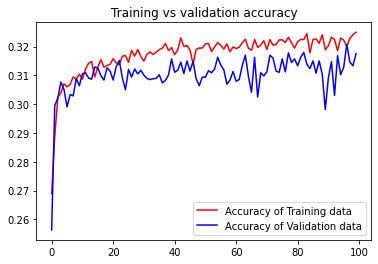

<Figure size 432x288 with 0 Axes>

In [23]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

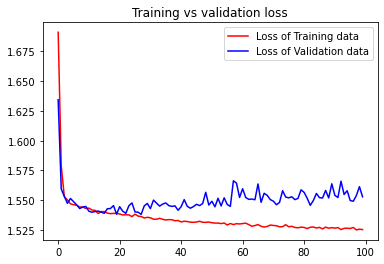

<Figure size 432x288 with 0 Axes>

In [24]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [25]:
pred2=model.predict(testX)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]
print(pd.Series(PRED).value_counts())

(4515, 5)
4    1488
0    1159
3     923
2     816
1     129
dtype: int64


In [26]:
ANS=testY0
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.3246954595791805


In [27]:
m=len(testX)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

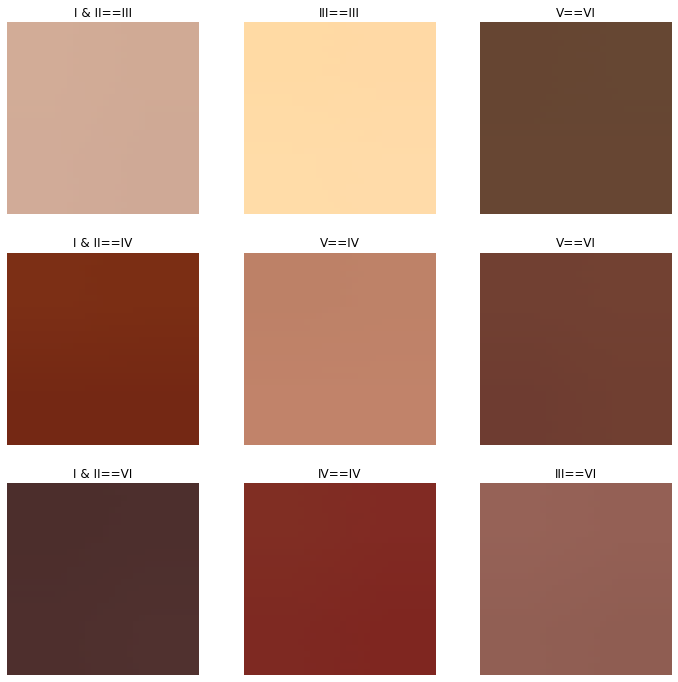

In [28]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
for i in range(9):
    r=i//3
    c=i%3
    img1 = testX[M[i]]
    ax=axs[r][c].axis("off")
    actual=reverse_mapping[testY0[M[i]]]
    predict=reverse_mapping[PRED[M[i]]]    
    ax=axs[r][c].set_title(actual+'=='+predict)
    ax=axs[r][c].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

# CNN model

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the number of classes
num_classes = 5

# Create the model
model1 = Sequential()

# Add convolutional layers
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))


# Add flatten layer
model1.add(Flatten())

# Add fully connected layers
model1.add(Dense(128, activation='relu'))

# Add output layer
model1.add(Dense(num_classes, activation='softmax'))

In [30]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [31]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [32]:
cnnModel=model1.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=100)

Epoch 1/100
886/886 [==============================] - 19s 21ms/step - loss: 2.6722 - accuracy: 0.2158 - val_loss: 1.6097 - val_accuracy: 0.1993
Epoch 2/100
886/886 [==============================] - 18s 20ms/step - loss: 1.6090 - accuracy: 0.2138 - val_loss: 1.6096 - val_accuracy: 0.1968
Epoch 3/100
886/886 [==============================] - 18s 21ms/step - loss: 1.6095 - accuracy: 0.1995 - val_loss: 1.6095 - val_accuracy: 0.1968
Epoch 4/100
886/886 [==============================] - 18s 20ms/step - loss: 1.6096 - accuracy: 0.1927 - val_loss: 1.6098 - val_accuracy: 0.1968
Epoch 5/100
886/886 [==============================] - 19s 21ms/step - loss: 1.6095 - accuracy: 0.2035 - val_loss: 1.6096 - val_accuracy: 0.2028
Epoch 6/100
886/886 [==============================] - 19s 21ms/step - loss: 1.6095 - accuracy: 0.1975 - val_loss: 1.6096 - val_accuracy: 0.2011
Epoch 7/100
886/886 [==============================] - 18s 20ms/step - loss: 1.6094 - accuracy: 0.2045 - val_loss: 1.6099 - val_ac

In [33]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.30      0.40      0.34      1413
           1       0.28      0.04      0.07      1416
           2       0.36      0.33      0.35      1425
           3       0.26      0.26      0.26      1437
           4       0.35      0.56      0.43      1394

    accuracy                           0.32      7085
   macro avg       0.31      0.32      0.29      7085
weighted avg       0.31      0.32      0.29      7085



In [34]:
pred2=model.predict(testX)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]
print(pd.Series(PRED).value_counts())

(4515, 5)
4    1488
0    1159
3     923
2     816
1     129
dtype: int64


In [35]:
ANS=testY0
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.3246954595791805


In [36]:
m=len(testX)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

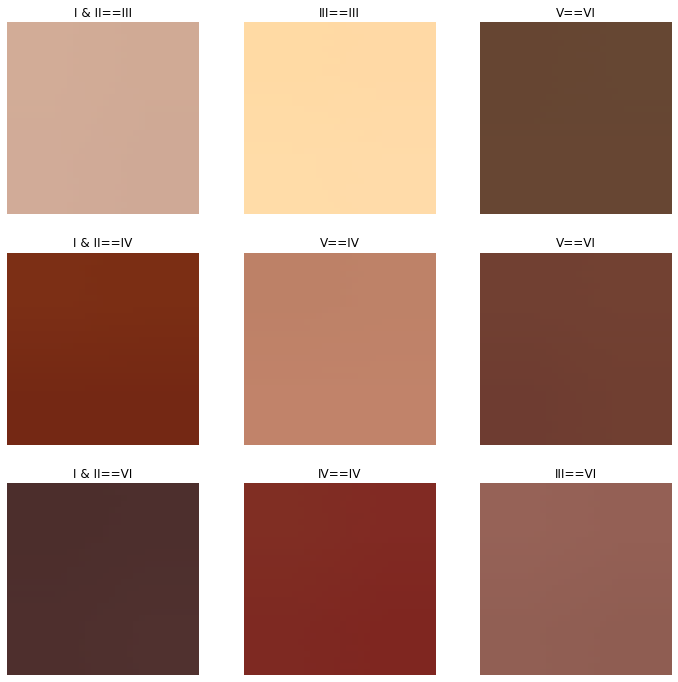

In [37]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
for i in range(9):
    r=i//3
    c=i%3
    img1 = testX[M[i]]
    ax=axs[r][c].axis("off")
    actual=reverse_mapping[testY0[M[i]]]
    predict=reverse_mapping[PRED[M[i]]]    
    ax=axs[r][c].set_title(actual+'=='+predict)
    ax=axs[r][c].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()